In [3]:
import numpy as np
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

%matplotlib inline

# Sampling from a linear model

In [4]:
phi = lambda a: torch.stack((a, a.pow(2), torch.ones_like(a)), -1)

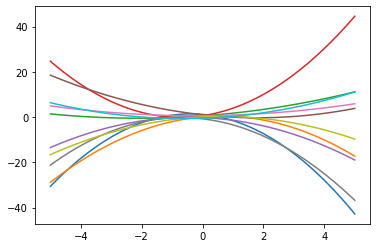

In [5]:
domain = torch.linspace(-5, 5, 100)
w = dist.Normal(0, 1).sample((3, 10))
f = phi(domain) @ w

plt.plot(domain, f);

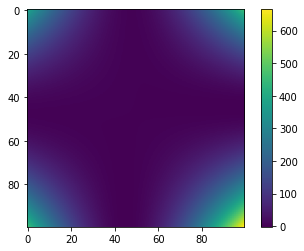

In [6]:
plt.imshow(np.cov(f));
plt.colorbar();

# Sampling from a Gaussian process with the corresponding kernel

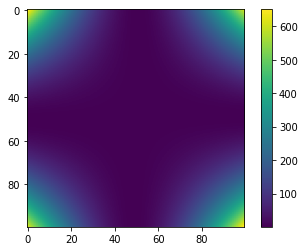

In [7]:
simple_kernel = lambda a, b: phi(a) @ phi(b).T
plt.imshow(simple_kernel(domain, domain));
plt.colorbar();

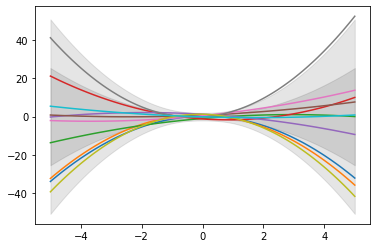

In [8]:
def plot_random_functions(domain, kernel, N_samples = 10):
    K = kernel(domain, domain)
    # sample from N(0, K):
    # L: LL' = K
    # f = L @ z, z ~ N(0, I)
    d, V = torch.linalg.eigh(K)
    L = d.clamp_min(0.0).sqrt() * V
    f = L @ torch.randn(L.shape[0], N_samples)
    
    std = K.diag().sqrt()
    plt.fill_between(domain, -std, std, color='k', alpha=0.1)
    plt.fill_between(domain, -2*std, 2*std, color='k', alpha=0.1)
    
    plt.plot(domain, f);
    
# N(0, K)
plot_random_functions(domain, simple_kernel);

In [9]:
def get_exp_kernel(lengthscale):
    return lambda a, b: (-0.5*(a.reshape(-1, 1) - b.reshape(1, -1)).pow(2)/(lengthscale**2)).exp()

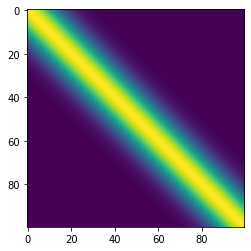

In [10]:
K = get_exp_kernel(1.0)(domain, domain)
plt.imshow(K);

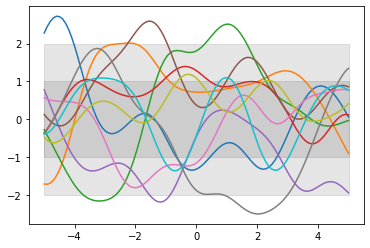

In [11]:
plot_random_functions(domain, get_exp_kernel(1));

# Conditioning the GP on data

In [12]:
def plot_conditional_functions(domain, kernel, X, y, sigma_n=0.01, N_samples = 10):

    
    Kxx = kernel(X, X) + sigma_n**2 * torch.eye(X.shape[0])
    Kx = kernel(domain, X)
    K = kernel(domain, domain)
    
    Kxx_inv = Kxx.inverse()
    
    mean = Kx @ (Kxx_inv @ y)
    Cov = K - Kx @ Kxx_inv @ Kx.T
    
    d, V = torch.linalg.eigh(Cov)
    L = d.clamp_min(0.0).sqrt() * V
    f = mean.unsqueeze(1) + L @ torch.randn(L.shape[0], N_samples)
    
    std = Cov.diag().sqrt()
    plt.fill_between(domain, mean-std, mean+std, color='k', alpha=0.1)
    plt.fill_between(domain, mean-2*std, mean+2*std, color='k', alpha=0.1)
    
    plt.plot(domain, f);

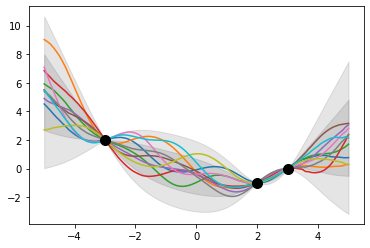

In [13]:
x_obs = torch.FloatTensor([-3, 2, 3])
y_obs = torch.FloatTensor([2, -1, 0])


domain = torch.linspace(-5, 5, 100)

add_kernels = lambda k1, k2: lambda a, b: (k1(a,b) + k2(a,b))

plot_conditional_functions(domain, add_kernels(simple_kernel, get_exp_kernel(1)), x_obs, y_obs, sigma_n=0);
plt.plot(x_obs, y_obs, 'ko', markersize=10);

# Feedforward network as kernel

In [39]:
import torch.nn as nn

class SimpleNetwork(nn.Module):
    
    def __init__(self, H, prior_std=1.0):
        super().__init__()
        self.hidden = nn.Sequential(nn.Linear(1, H), nn.Tanh())
        self.out = nn.Linear(H, 1)
        
        # "initialize" with random sample from the prior
        for param in self.hidden.parameters():
            nn.init.normal_(param, 0, prior_std)
        for param in self.out.parameters():
            nn.init.normal_(param, 0, prior_std)
            
    def forward(self, x):
        h = self.hidden(x.reshape(-1, 1))
        f = self.out(h)
        return f.reshape(x.shape)

### Sampling random neural networks

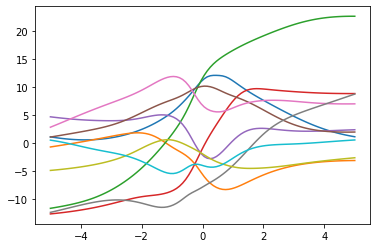

In [40]:
with torch.no_grad():
    for _ in range(10):
        plt.plot(domain, SimpleNetwork(100)(domain))

### What happens if we actually fit the NN to the data?

In [41]:
def fit_simple_network(H, sigma_n, X, y):
    model = SimpleNetwork(H)
    opt = torch.optim.Adagrad(model.parameters(), lr=0.1)
#     losses = []
    for _ in range(50):
        opt.zero_grad()
        lp = dist.Normal(0, 1.0).log_prob(nn.utils.parameters_to_vector(model.parameters())).sum()
        ll = dist.Normal(model(X), sigma_n).log_prob(y).sum()
        loss = -(ll + lp)
        loss.backward()
        opt.step()
#         losses.append(loss.item())
#         plt.plot(losses)
    return model

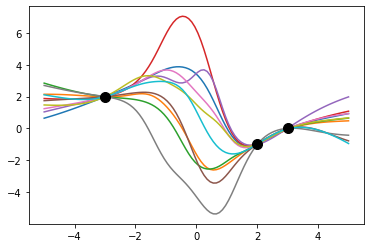

In [42]:
sigma_n = 0.1

for _ in range(10):
    model = fit_simple_network(100, sigma_n, x_obs, y_obs)
    with torch.no_grad():
        plt.plot(domain, model(domain))
plt.plot(x_obs, y_obs, 'ko', markersize=10);

### Compare with NN-GP

In [43]:
def make_nn_kernel(H, prior_std=1.0, K=30):
    net = [SimpleNetwork(H) for _ in range(K)]
    def nn_kernel(a, b):
        with torch.no_grad():
            h_a = torch.stack([f.hidden(a[:,None]) for f in net])
            h_b = torch.stack([f.hidden(b[:,None]) for f in net])
        V = (h_a.reshape(K, len(a), 1, -1) * h_b.reshape(K, 1, len(b), -1)).sum(-1)
        # V is [K, len(a), len(b)]
        V = V.mean(0) # does the sample average across K
        return prior_std**2 + prior_std**2 * V
    return nn_kernel

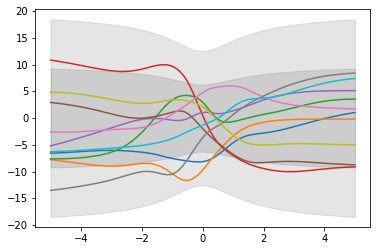

In [44]:
nn_kernel = make_nn_kernel(100, K=30)

plot_random_functions(domain, nn_kernel)

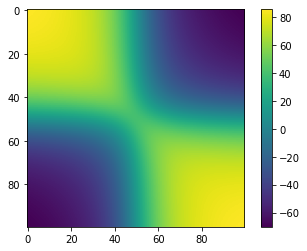

In [45]:
plt.imshow(nn_kernel(domain, domain));
plt.colorbar();

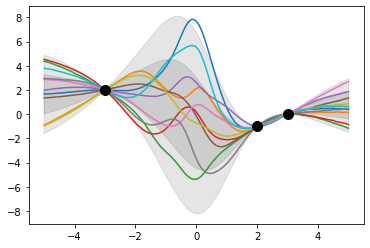

In [46]:
plot_conditional_functions(domain, nn_kernel, x_obs, y_obs, sigma_n=0.01);
plt.plot(x_obs, y_obs, 'ko', markersize=10);

# Neural tangent kernel

In [47]:
def make_ntk_features(H, prior_std, K=30):
    net = [SimpleNetwork(H, prior_std) for _ in range(K)]
    
    def phi_ntk(points):
        tmp = lambda x, m: nn.utils.parameters_to_vector(torch.autograd.grad(m(x), m.parameters()))
        return torch.stack([torch.stack([tmp(x, m) for x in points]) for m in net]).mean(0)

    return phi_ntk

phi_ntk = make_ntk_features(101, 1.0)
ntk_kernel = lambda a, b: phi_ntk(a) @ phi_ntk(b).T

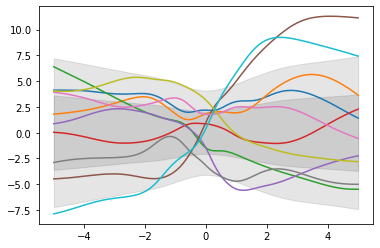

In [48]:
plot_random_functions(domain, ntk_kernel);

### Black dashed lines are trained networks

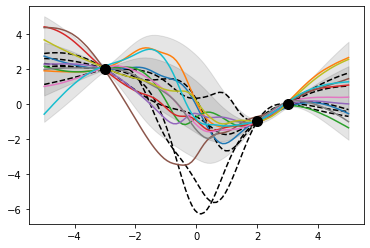

In [49]:
for _ in range(5):
    model = fit_simple_network(101, sigma_n, x_obs, y_obs)
    with torch.no_grad():
        plt.plot(domain, model(domain), 'k--')

plot_conditional_functions(domain, ntk_kernel, x_obs, y_obs, sigma_n=sigma_n);
plt.plot(x_obs, y_obs, 'ko', markersize=10);


# EXERCISE: go back and change the "SimpleNetwork" to something less simple

* Swap out the `nn.Tanh()` for `nn.ReLU()`?
* Add a second hidden layer? (**NOTE:** this may require modifying the code for the NN-GP)